# Recommending movies using collaborative filtering

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Data

To build a recommender system, we need data to learn from. Specifically, we need the a dataset of **ratings** that different **users** assigend to different **items**, i.e., the movies. Let's start by loading the data and look at the first few rows.

In [2]:
ratings = pd.read_csv(
    '../datasets/u.data',
    delimiter='\t',
    header=None,
    names=['user_id', 'item_id', 'rating', 'timestamp']
) 

# We don't need the column timestamp, so we drop it
ratings.drop('timestamp', axis=1 , inplace=True)

ratings.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


## Exercise 1.1: Similarity-based

**Question 1:** Implement the similarity-based algorithm given by the formulas of exercise 1.1

The calculations for the similarity-based method require frequent filtering of the data, e.g., getting all movies rated by a particular user and getting all users who rated a particular movie. We use the indexing mechanisms in `pandas` in order to facilitate and speed up these operations.

In [3]:
user_means = ratings.groupby('user_id')['rating'].mean()

# Creates a new index data structures
ratings_ui = ratings.set_index(['user_id', 'item_id'])
ratings_iu = ratings.set_index(['item_id', 'user_id'])

print('ratings_ui: users, then movies')
display(ratings_ui.head())
print('ratings_iu: movies, then users')
display(ratings_iu.head())

print('ratings_iu: part of the index for movie 242')
display(ratings_iu.loc[242].head())

ratings_ui: users, then movies


,,rating
user_id,item_id,
196,242,3
186,302,3
22,377,1
244,51,2
166,346,1


ratings_iu: movies, then users


,,rating
item_id,user_id,
242,196,3
302,186,3
377,22,1
51,244,2
346,166,1


ratings_iu: part of the index for movie 242


,rating
user_id,
196,3
63,3
226,5
154,3
306,5


Using these indexes, we can now implement a function that computes the similarity between a user `u` and another user `v`

In [4]:
def similarity(u, v):
    
    u_ratings = ratings_ui.loc[u]
    v_ratings = ratings_ui.loc[v]
    
    Ru = user_means.loc[u]
    Rv = user_means.loc[v]
    
    common_movies = pd.merge(u_ratings, v_ratings, 
                             left_index = True, right_index = True, 
                             suffixes=('_u', '_v'),
                             how='inner')
    
    if (common_movies.empty):
        return 0.0
    
    common_movies['rating_u'] -= Ru
    common_movies['rating_v'] -= Rv
    
    common_movies['RujRvj'] = common_movies['rating_u'] * common_movies['rating_v'] 
    common_movies['RujRuj'] = common_movies['rating_u'] * common_movies['rating_u'] 
    common_movies['RvjRvj'] = common_movies['rating_v'] * common_movies['rating_v'] 
    
    denom1 = common_movies['RujRuj'].sum()
    denom2 = common_movies['RvjRvj'].sum()
    
    if denom1 == 0 or denom2 == 0:
        return 0.0

    return np.round(common_movies['RujRvj'].sum() / np.sqrt(denom1 * denom2),4)

**Question 2:** Let's now use the similarity function to find similar users. Given a user `u`, find the
- user that is the most similar (positively correlated) to `u`;
- user that is the least similar (negatively correlated) to `u`;
- user that is weakly correlated to `u`.

What can you say about the influence that these three users will have on the ratings of user `u`?

In [5]:
u = 1
list_users = ratings['user_id'].unique()
list_users = list_users[np.where(list_users != u)[0]]
list_similarities = np.array([similarity(1, v) for v in list_users])
user_poscorr = list_users[np.argmax(list_similarities)]
user_negcorr = list_users[np.argmin(list_similarities)]
user_uncorr = list_users[np.argmin(np.abs(list_similarities))]

print('User positively correlated: user', user_poscorr,'with similarity =', similarity(u, user_poscorr))
print('User negatively correlated: user', user_negcorr,'with similarity =', similarity(u, user_negcorr))
print('User weakly correlated: user', user_uncorr,'with similarity =', similarity(u, user_uncorr))

User positively correlated: user 155 with similarity = 1.0
User negatively correlated: user 88 with similarity = -1.0
User weakly correlated: user 24 with similarity = -0.0001


In order to use the similarity function for predicting the rating of a movie for a given user, we need to find all other users that rated that movie, and compute the predicted rating as sum of the ratings of these users, weighted by similarity.

In [6]:
def predict(user_id, movie_id):
    # Find all users who rated the given movie
    co_raters = ratings_iu.loc[movie_id].copy()
    
    # Compute similarity with each co-rater for the movie
    # `v.name` retrieves the index value, i.e., the user id of v
    co_raters['similarity'] = co_raters.apply(axis=1, func=lambda v: similarity(user_id, v.name)) 
    co_raters['rating'] -= user_means[co_raters.index]
    
    alpha = co_raters['similarity'].abs().sum()
    
    prediction = (co_raters['similarity'] * co_raters['rating']).sum()
    
    return user_means[user_id] + prediction / alpha

**Question 3:** Use your implementation to predict an unknown rating of the dataset. What is the run time of your implementation? Can you think of ways to speed it up?

Let's use this function to predict the rating of the movie *Outbreak* (which has id 54) for user 1:

In [7]:
user = 1
movie_to_predict = 54
%time predict(user, movie_to_predict)

CPU times: user 556 ms, sys: 64 µs, total: 556 ms
Wall time: 555 ms


3.355353324648658

## Exercise 1.2: Model-based

To make our life easier, we will now use the [Surprise](https://surprise.readthedocs.io) Python package which implements a variety of collaborative filtering algorithms. To install this package, simply run `pip install surprise` or use conda if you use Windows: open anaconda navigator, go to environments, click on the arrow next to the base (root) environment, click "open terminal" and run the following command: `conda install -y -c conda-forge scikit-surprise`.

In [8]:
import surprise

First, we need to convert our dataset to a format where the rows represent users and the columns represent the movies. The value at each cell is the rating for corresponding user and movie, or zero if the user did not rate the movie.

In [9]:
from surprise.dataset import Dataset, Reader
dataset = Dataset.load_from_df(ratings, reader=Reader(rating_scale=(1, 5)))
X = dataset.build_full_trainset()

**Question 4:** Now use the non-negative matrix factorization implementation of this package to predict the rating for a given user and movie.

Hint: you'll need the [surprise.prediction_algorithms.matrix_factorization.NMF](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF) class.

In [14]:
from surprise.prediction_algorithms.matrix_factorization import NMF
nmf = NMF().fit(X)

In [11]:
user = 1
movie_to_predict = 54
%time nmf.predict(user, movie_to_predict)

CPU times: user 62 µs, sys: 4 µs, total: 66 µs
Wall time: 68.2 µs


Prediction(uid=1, iid=54, r_ui=None, est=3.3696010802284433, details={'was_impossible': False})

**Question 5:** What is the effect of the number of latent factors? Is there an optimal number of factors?

Hint: the [surprise.model_selection.search.GridSearchCV](https://surprise.readthedocs.io/en/stable/model_selection.html#surprise.model_selection.search.GridSearchCV) makes it easy to compare different parameter settings (note that GridSearchCV.fit expects a Dataset object instead of a Trainset object)

In [12]:
from surprise.model_selection import GridSearchCV
param_grid = {"n_factors": [1, 2, 5, 10, 20, 50, 100, 200]}
search = GridSearchCV(NMF, param_grid, cv=3, n_jobs=4)
search.fit(dataset)

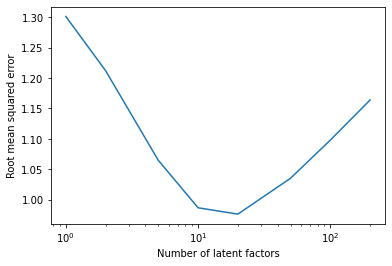

In [13]:
import matplotlib.pyplot as plt
plt.semilogx(param_grid["n_factors"], search.cv_results['mean_test_rmse'])
plt.xlabel("Number of latent factors")
plt.ylabel("Root mean squared error")
plt.show()